In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

sns.set(style="whitegrid")


In [2]:
processed_path = r"C:\Users\assef\Desktop\Kifiya AI Mastery\week4\credit-risk-model\data\processed"

task3_df = pd.read_csv(f"{processed_path}/task3_features.csv")
task4_df = pd.read_csv(f"{processed_path}/task4_features.csv")

df = task3_df.merge(
    task4_df[['CustomerId', 'is_high_risk']],
    on='CustomerId',
    how='inner'
)

df.head()


,CustomerId,total_amount,avg_amount,transaction_count,std_amount,avg_tx_hour,avg_tx_day,common_tx_month,channel,product_category,provider,is_high_risk
0,CustomerId_1,-10000.0,-10000.000000,1,5389.779013,16.000000,21.000000,11,ChannelId_2,airtime,ProviderId_4,1
1,CustomerId_10,-10000.0,-10000.000000,1,5389.779013,16.000000,21.000000,11,ChannelId_2,airtime,ProviderId_4,1
2,CustomerId_1001,20000.0,4000.000000,5,6558.963333,7.800000,16.000000,11,ChannelId_3,financial_services,ProviderId_4,1
3,CustomerId_1002,4225.0,384.090909,11,560.498966,13.454545,14.727273,11,ChannelId_2,financial_services,ProviderId_4,0
4,CustomerId_1003,20000.0,3333.333333,6,6030.478146,14.333333,1.000000,2,ChannelId_3,airtime,ProviderId_6,0


In [3]:
X = df.drop(columns=['CustomerId', 'is_high_risk'])
y = df['is_high_risk']

numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [4]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

trained_models = {}

for name, model in models.items():
    pipeline = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline


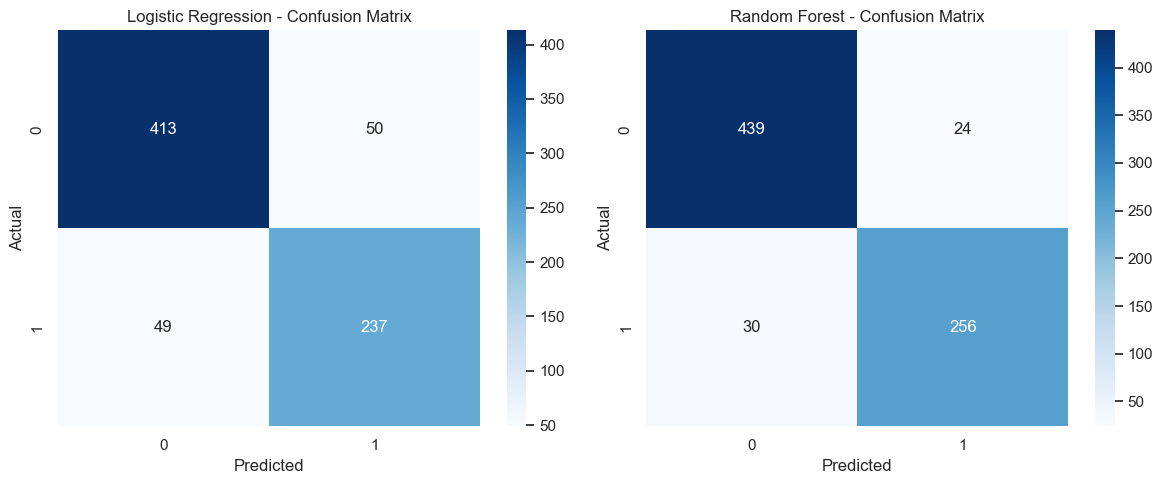

In [5]:
plt.figure(figsize=(12, 5))

for i, (name, model) in enumerate(trained_models.items(), 1):
    plt.subplot(1, 2, i)
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


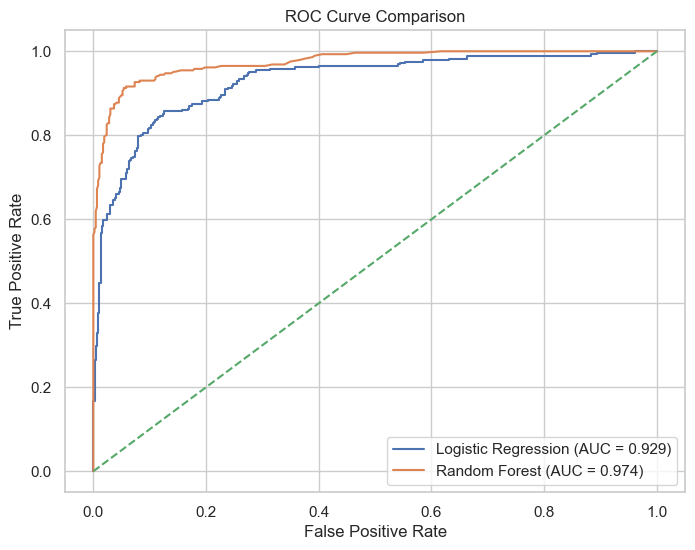

In [6]:
plt.figure(figsize=(8, 6))

for name, model in trained_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


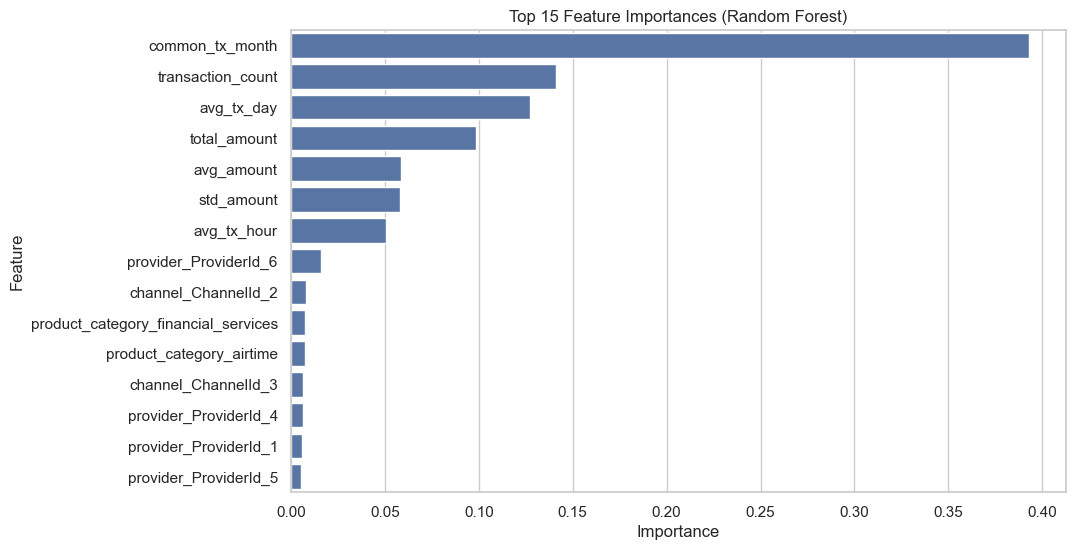

In [7]:
rf_model = trained_models["Random Forest"]

feature_names = (
    numeric_features +
    list(
        rf_model.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
)

importances = rf_model.named_steps['model'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


### Model Evaluation and Visualization

Confusion matrices were used to evaluate classification performance, highlighting the trade-off between false positives and false negatives.  
ROC curves demonstrate that the Random Forest model outperformed Logistic Regression with a higher AUC score, indicating stronger discriminatory power.

Feature importance analysis shows that transaction amount statistics and transaction frequency are the most influential predictors of credit risk.
